In [1]:
import sys
import json
params = {}
default = {'training_folder': '../../scenarios/houston/', 'params': params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/houston/', 'params': {}}


In [2]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

PyTables is not installed. No support for HDF output.
num cores: 8


In [3]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

In [4]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
od_folder =  os.path.join(input_folder,'od/')
params_folder = input_folder if on_lambda else '../../inputs/'

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(input_folder, 'model/')

In [5]:
sm = stepmodel.read_zippedpickles(model_folder +'los')
sm.segments = ['car_owner', 'pt_captive'] 

zones: 100%|██████████| 28/28 [00:04<00:00,  6.85it/s]          


In [6]:
var = excel.read_var(file=os.path.join(params_folder,'parameters.xlsx'), scenario='base', return_ancestry=False)
kwargs = var['preparation_logit'].to_dict()

utility_scale = var['preparation_logit']['time']
kwargs['transfers'] = -kwargs['transfers']/utility_scale # From min/transfer to pt/transfer
kwargs['price'] = -60/kwargs['price']/utility_scale # From 
kwargs['time'] = -1/utility_scale/60 # From min/pt to pt/sec
kwargs


{'time': -0.0008333333333333334,
 'price': -0.2,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1,
 'transfers': -0.25}

In [7]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [8]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.000833,-0.2,-0.25,1.0
car_owner,-0.000833,-0.2,-0.25,1.0
pt_captive,-0.000833,-0.2,-0.25,1.0


In [9]:
sm.logit_scales.T 

route_type,tram,car,walk,bus,root,pt
segment,,,,,,
root,0.1,0.0,0.0,0.1,1.0,0.5
car_owner,0.1,0.0,0.0,0.1,1.0,0.5
pt_captive,0.1,0.0,0.0,0.1,1.0,0.5


In [10]:
sm.mode_utility.T

route_type,tram,car,walk,bus,root
segment,,,,,
root,0,0,0,0,0
car_owner,0,0,0,0,0
pt_captive,0,0,0,0,0


In [11]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility.T

route_type,tram,car,walk,bus,root
segment,,,,,
root,0,0,0,0,0
car_owner,0,0,0,0,0
pt_captive,0,-100,0,0,0


In [12]:
sm.mode_nests.T 

route_type,tram,car,walk,bus,root,pt
segment,,,,,,
root,pt,root,root,pt,NaN,root
car_owner,pt,root,root,pt,NaN,root
pt_captive,pt,root,root,pt,NaN,root


In [13]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0  ######
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

In [14]:
sm.analysis_pt_time(
        boarding_time=None,
        alighting_time=None,
        walk_on_road=True,
    )
 

sm.analysis_car_route_type() 

sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p)) 


sm.analysis_mode_utility()

100%|██████████| 2/2 [00:00<00:00, 37.40it/s]


In [15]:
sm.initialize_logit()
sm.step_logit()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


In [16]:
sm.volumes.fillna(0, inplace=True)
sm.compute_los_volume(keep_segments=False)

In [17]:
sm.los['volume'].sum()

3574545.499281494

In [18]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']

In [19]:
sm.step_pt_assignment(
    road=True,
    boardings=True,
    alightings=True,
    transfers=True
 
)

pt_captive: 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


In [20]:
sm.links.rename(columns={'load': 'volume'}, inplace=True)
sm.analysis_pt_length(
     walk_on_road=True
)
sm.analysis_car_length()
sm.analysis_pt_time(
     walk_on_road=True
)

In [21]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

In [22]:
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)

In [23]:
sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [24]:
sm.probabilities.groupby(['segment'])['pt'].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
car_owner,67780.0,0.004983,0.021535,0.0,1.829612e-12,4.691556e-07,0.000312,0.406207
pt_captive,67780.0,0.918899,0.272992,0.0,1.000000e+00,1.000000e+00,1.000000,1.000000


In [25]:
sm.probabilities.loc[sm.probabilities['segment'] == 'car_owner'].sort_values(by='pt', ascending=False).head()

route_type,origin,destination,segment,root,walk,car,pt,bus,tram
12386,zone_58,zone_242,car_owner,1,0.0,0.593793,0.406207,0.406207,0.0
9530,zone_416,zone_154,car_owner,1,0.0,0.617625,0.382375,0.382375,0.0
4028,zone_274,zone_196,car_owner,1,0.0,0.617954,0.382046,0.382046,0.0
2442,zone_196,zone_274,car_owner,1,0.0,0.628041,0.371959,0.371959,0.0
9562,zone_445,zone_109,car_owner,1,0.0,0.629095,0.370905,0.370905,0.0


In [26]:
sm.links['boardings'].sum()


1804819.6103978134

In [27]:
sm.car_los

,origin,destination,time,path,gtime,node_path,link_path,ntlegs,ntransfers,price,route_types,route_type,access_length,in_vehicle_length,length
0,zone_404,zone_154,2776.453535,"[zone_404, road_node_67902, road_node_74831, r...",2776.453535,"[road_node_67902, road_node_74831, road_node_4...","[road_link_29486_r, road_link_67809, road_link...","[(zone_404, road_node_67902), (road_node_58137...",0,0,"(car,)",car,549.922938,52022.159939,52572.082877
1,zone_349,zone_478,2098.705954,"[zone_349, road_node_51654, road_node_24698, r...",2098.705954,"[road_node_51654, road_node_24698, road_node_5...","[road_link_38528, road_link_68085, road_link_6...","[(zone_349, road_node_51654), (road_node_88294...",0,0,"(car,)",car,485.515606,38873.743930,39359.259536
2,zone_170,zone_404,2436.501669,"[zone_170, road_node_81193, road_node_20522, r...",2436.501669,"[road_node_81193, road_node_20522, road_node_1...","[road_link_75273, road_link_29993, road_link_3...","[(zone_170, road_node_81193), (road_node_67902...",0,0,"(car,)",car,504.675142,46774.630017,47279.305159
3,zone_374,zone_477,923.627053,"[zone_374, road_node_31731, road_node_27344, r...",923.627053,"[road_node_31731, road_node_27344, road_node_5...","[road_link_30159, road_link_67915, road_link_6...","[(zone_374, road_node_31731), (road_node_50947...",0,0,"(car,)",car,453.275597,6107.750099,6561.025696
4,zone_35,zone_300,959.175640,"[zone_35, road_node_71848, road_node_80431, ro...",959.175640,"[road_node_71848, road_node_80431, road_node_8...","[road_link_9180, road_link_53337, road_link_16...","[(zone_35, road_node_71848), (road_node_70686,...",0,0,"(car,)",car,447.058985,7126.323562,7573.382547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67775,zone_345,zone_1,3140.304920,"[zone_345, road_node_90196, road_node_81764, r...",3140.304920,"[road_node_90196, road_node_81764, road_node_7...","[road_link_7481, road_link_28798, road_link_43...","[(zone_345, road_node_90196), (road_node_41370...",0,0,"(car,)",car,770.085164,59257.566265,60027.651429
67776,zone_278,zone_323,51458.297367,"[zone_278, road_node_28751, road_node_68527, r...",51458.297367,"[road_node_28751, road_node_68527, road_node_5...","[road_link_44076, road_link_57160, road_link_2...","[(zone_278, road_node_28751), (road_node_48701...",0,0,"(car,)",car,35231.739052,164249.692633,199481.431685
67777,zone_10,zone_139,32204.442229,"[zone_10, road_node_17356, road_node_54488, ro...",32204.442229,"[road_node_17356, road_node_54488, road_node_7...","[road_link_63098, road_link_8723, road_link_63...","[(zone_10, road_node_17356), (road_node_2797, ...",0,0,"(car,)",car,21780.318986,103712.502190,125492.821176
67778,zone_144,zone_170,2181.549912,"[zone_144, road_node_81077, road_node_376, roa...",2181.549912,"[road_node_81077, road_node_376, road_node_106...","[road_link_56287_r, road_link_39738_r, road_li...","[(zone_144, road_node_81077), (road_node_64100...",0,0,"(car,)",car,442.865738,40278.443047,40721.308785


In [28]:
sm.utilities

route_type,origin,destination,segment,root,walk,car,pt,bus,tram
0,zone_102,zone_1,car_owner,-3.240568,-inf,-3.240568,-17.096860,-17.096860,-inf
1,zone_102,zone_1,pt_captive,-17.096860,-inf,-103.240568,-17.096860,-17.096860,-inf
2,zone_102,zone_103,car_owner,-3.402784,-inf,-3.402784,-20.487642,-20.487642,-inf
3,zone_102,zone_103,pt_captive,-20.487642,-inf,-103.402784,-20.487642,-20.487642,-inf
4,zone_102,zone_104,car_owner,-2.084219,-inf,-2.084239,-12.884020,-12.884020,-inf
...,...,...,...,...,...,...,...,...,...
12909,zone_94,zone_488,pt_captive,-33.051515,-inf,-104.092217,-33.051515,-33.051515,-inf
12910,zone_94,zone_58,car_owner,-4.446977,-inf,-4.446977,-35.393180,-35.393180,-inf
12911,zone_94,zone_58,pt_captive,-35.393180,-inf,-104.446977,-35.393180,-35.393180,-inf
12912,zone_94,zone_77,car_owner,-4.149889,-inf,-4.149889,-34.532016,-34.532016,-inf


In [29]:
sm.probabilities

route_type,origin,destination,segment,root,walk,car,pt,bus,tram
0,zone_102,zone_1,car_owner,1,0.0,9.999990e-01,9.600387e-07,9.600387e-07,0.0
1,zone_102,zone_1,pt_captive,1,0.0,3.874919e-38,1.000000e+00,1.000000e+00,0.0
2,zone_102,zone_103,car_owner,1,0.0,1.000000e+00,3.803122e-08,3.803122e-08,0.0
3,zone_102,zone_103,pt_captive,1,0.0,9.781636e-37,1.000000e+00,1.000000e+00,0.0
4,zone_102,zone_104,car_owner,1,0.0,9.999796e-01,2.040355e-05,2.040355e-05,0.0
...,...,...,...,...,...,...,...,...,...
12909,zone_94,zone_488,pt_captive,1,0.0,1.404155e-31,1.000000e+00,1.000000e+00,0.0
12910,zone_94,zone_58,car_owner,1,0.0,1.000000e+00,3.632741e-14,3.632741e-14,0.0
12911,zone_94,zone_58,pt_captive,1,0.0,1.024041e-30,1.000000e+00,1.000000e+00,0.0
12912,zone_94,zone_77,car_owner,1,0.0,1.000000e+00,6.385726e-14,6.385726e-14,0.0


In [30]:
sm.od_los

segment                  car_owner                                   \
sum                         volume price       time in_vehicle_time   
origin  destination mode                                              
zone_0  zone_1      bus   0.008931   0.0   4.285161        1.885705   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_104    bus   0.684262   0.0  46.308404       32.382759   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_109    bus   0.367206   0.0  56.616397       30.689838   
...                            ...   ...        ...             ...   
zone_99 zone_85     car   0.000000   0.0   0.000000        0.000000   
        zone_87     bus   0.000002   0.0   0.001500        0.000256   
                    car   0.000000   0.0   0.000000        0.000000   
        zone_90     car   0.000000   0.0   0.000000        0.000000   
                    walk  0.000001   0.0   0.000584        0.000000   

segment                                                  pt_captive        \
sum                      in_vehicle_length    ntransfers     volume price   
origin  destination mode                                                    
zone_0  zone_1      bus          29.907679  1.064368e-03   0.000000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_104    bus         208.391380  1.359192e-02  50.702857   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_109    bus         434.771484  2.194744e-02   0.000000   0.0   
...                                    ...           ...        ...   ...   
zone_99 zone_85     car           0.000000  0.000000e+00   0.000000   0.0   
        zone_87     bus           0.003252  6.439803e-08  25.475000   0.0   
                    car           0.000000  0.000000e+00   0.000000   0.0   
        zone_90     car           0.000000  0.000000e+00   0.000000   0.0   
                    walk          0.000000  0.000000e+00   0.000000   0.0   

segment                                                                   \
sum                               time in_vehicle_time in_vehicle_length   
origin  destination mode                                                   
zone_0  zone_1      bus   12078.042640          5315.0           84297.0   
                    car       0.000000             0.0               0.0   
        zone_104    bus    6814.105732          4765.0           30664.0   
                    car       0.000000             0.0               0.0   
        zone_109    bus    7738.906510          4195.0           59429.0   
...                                ...             ...               ...   
zone_99 zone_85     car       0.000000             0.0               0.0   
        zone_87     bus   23299.386085          3970.0           50504.0   
                    car       0.000000             0.0               0.0   
        zone_90     car       0.000000             0.0               0.0   
                    walk  24321.227058             0.0               0.0   

segment                                   root                      \
sum                      ntransfers     volume price          time   
origin  destination mode                                             
zone_0  zone_1      bus         3.0   0.008931   0.0      4.285161   
                    car         0.0   0.000000   0.0      0.000000   
        zone_104    bus         2.0  51.387119   0.0   6723.986938   
                    car         0.0   0.000000   0.0      0.000000   
        zone_109    bus         3.0   0.367206   0.0     56.616397   
...                             ...        ...   ...           ...   
zone_99 zone_85     car         0.0   0.000000   0.0      0.000000   
        zone_87     bus         1.0  25.475002   0.0  23299.384609   
                    car         0.0   0.000000   0.0      0.000000   
        zone_90     c

In [31]:
sm.to_zippedpickles(model_folder + 'logit_assignment')

stack_aggregated_link_max: 100%|██████████| 47/47 [00:22<00:00,  2.11it/s]


In [32]:
od_list= sm.volumes.loc[sm.volumes['pt_captive']==0.001][['origin','destination']].values.tolist()

In [33]:
sm.pt_los.set_index(['origin','destination']).loc[od_list]

,,gtime,path,pathfinder_session,reversed,route_id_set,route_type_set,boardings,alightings,node_path,link_path,...,"(car_owner, probability)","(pt_captive, probability)",car_owner,pt_captive,volume,pivot,access_length,footpath_length,in_vehicle_length,length
origin,destination,,,,,,,,,,,,,,,,,,,,,
zone_446,zone_83,8003.531299,"(zone_446, 3455, link_1355, link_1356, link_13...",best_path,False,"{HOU_008, HOU_003}","{bus, tram}","[3455, 1786, 512]","[460, 512, 629]","[3455, 460, 1786, 512, 629]","[link_1355, link_1356, link_1357, link_1358, l...",...,0.003459,1.0,0.0,0.001,0.001,1.0,501.978521,343.431511,34363.0,35208.410032
zone_239,zone_443,12516.741854,"(zone_239, road_node_28422, road_node_60745, r...",best_path,False,"{HOU_096, HOU_228}",{bus},"[2270, 1014, 1115]","[4162, 817, 673]","[road_node_28422, road_node_60745, road_node_3...","[link_12043, link_12044, link_12045, link_1204...",...,0.000091,1.0,0.0,0.001,0.001,1.0,256.229925,8924.078173,44622.0,53802.308098
zone_386,zone_300,4903.993637,"(zone_386, road_node_30783, road_node_63616, r...",best_path,False,"{HOU_050, HOU_009}",{bus},"[64, 845]","[845, 377]","[road_node_30783, road_node_63616, road_node_9...","[link_1446, link_1447, link_1448, link_1449, l...",...,0.037026,1.0,0.0,0.001,0.001,1.0,485.930039,747.826052,19473.0,20706.756091
zone_137,zone_144,5000.791272,"(zone_137, road_node_56631, road_node_81882, r...",best_path,False,"{HOU_137, HOU_020}",{bus},"[139, 2997]","[2997, 2853]","[road_node_56631, road_node_81882, road_node_5...","[link_2026, link_2027, link_2028, link_2029, l...",...,0.035055,1.0,0.0,0.001,0.001,1.0,443.487289,1270.439679,17563.0,19276.926968
zone_488,zone_4,4447.897741,"(zone_488, 1357, link_4793, link_4794, link_47...",best_path,False,"{HOU_002, HOU_044}","{bus, tram}","[1357, 2882, 2009]","[1234, 1016, 1368]","[1357, 1234, 2882, 1016, 2009, 1368]","[link_4793, link_4794, link_4795, link_4796, l...",...,0.036056,1.0,0.0,0.001,0.001,1.0,766.189707,254.320738,11462.0,12482.510445
zone_203,zone_247,5358.580717,"(zone_203, 1170, link_7924, link_7925, link_79...",best_path,False,"{HOU_085, HOU_070}",{bus},"[1170, 804]","[129, 1439]","[1170, 129, 804, 1439]","[link_7924, link_7925, link_7926, link_7927, l...",...,0.017761,1.0,0.0,0.001,0.001,1.0,1126.854963,97.681698,10169.0,11393.536660
zone_176,zone_298,8587.585470,"(zone_176, road_node_2114, road_node_62594, ro...",best_path,False,"{HOU_029, HOU_216}","{bus, tram}","[2364, 1379, 1392]","[1379, 1392, 1391]","[road_node_2114, road_node_62594, road_node_73...","[link_12013, link_12014, link_12015, link_1201...",...,0.005216,1.0,0.0,0.001,0.001,1.0,1236.938982,2413.147223,35905.0,39555.086205
zone_174,zone_488,4846.048396,"(zone_174, 2016, link_11081, link_11082, link_...",best_path,False,"{HOU_102, HOU_044}",{bus},"[2016, 3987]","[2169, 1357]","[2016, 2169, road_node_66212, road_node_38818,...","[link_11081, link_11082, link_11083, link_1108...",...,0.065188,1.0,0.0,0.001,0.001,1.0,328.185686,101.327571,42982.0,43411.513257
zone_382,zone_179,3781.322122,"(zone_382, 108, link_174, link_175, link_176, ...",best_path,False,"{HOU_002, HOU_046}",{bus},"[108, 1794]","[2298, 789]","[108, 2298, 1794, 789]","[link_174, link_175, link_176, link_177, link_...",...,0.065914,1.0,0.0,0.001,0.001,1.0,189.920321,159.957781,15878.0,16227.878102


In [34]:
sm.probabilities.set_index(['segment', 'origin', 'destination']).loc['car_owner'].loc[od_list]

,route_type,root,walk,car,pt,bus,tram
origin,destination,,,,,,
zone_446,zone_83,1,0.0,0.996541,0.003459,0.000000,0.003459
zone_239,zone_443,1,0.0,0.999909,0.000091,0.000091,0.000000
zone_386,zone_300,1,0.0,0.962974,0.037026,0.037026,0.000000
zone_137,zone_144,1,0.0,0.964945,0.035055,0.035055,0.000000
zone_488,zone_4,1,0.0,0.963944,0.036056,0.000000,0.036056
zone_203,zone_247,1,0.0,0.982239,0.017761,0.017761,0.000000
zone_176,zone_298,1,0.0,0.994784,0.005216,0.000000,0.005216
zone_174,zone_488,1,0.0,0.934812,0.065188,0.065188,0.000000
zone_382,zone_179,1,0.0,0.934086,0.065914,0.065914,0.000000


In [35]:
sm.links['boardings'].sum()

1804819.6103978134

In [36]:
sm.links['volume'].max()

45115.47135845348

In [37]:
sm.volumes['pt_captive'].sum()

714964.2089999998

In [38]:
sm.volumes['car_owner'].sum()

2859581.290281494

In [39]:

import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

In [40]:
plot_sm = sm.copy()

In [41]:
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.01]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)

In [42]:
od_test = gpd.read_file(od_folder + 'od.geojson')
od_test

,index,name,geometry
0,OD_5nwQ3SHNgfacXXEdm3ogc9,iah_to_houston,"LINESTRING (-95.34102 29.97519, -95.36370 29.7..."
1,OD_w8x89yAmcwWEruT3YWj1f7,houston_to_westUniversity,"LINESTRING (-95.37484 29.75654, -95.43686 29.7..."
2,OD_iC14u8DBayGqUmcbTW7V1J,pasadena_to_houston,"LINESTRING (-95.22000 29.69247, -95.36349 29.7..."
3,OD_jE4guBZ7cGZNRtvG9FMFVv,jersey_to_UniversityOfHouston,"LINESTRING (-95.56699 29.89384, -95.33808 29.7..."
4,OD_nz66BddM1fySVmswL4ZcFr,bunkerVillage_to_memorialGolfCourse,"LINESTRING (-95.53154 29.76164, -95.44213 29.7..."
5,OD_f2evV6JggMiPGeTuqmrCxU,houstonHeights_to_riceUniversity,"LINESTRING (-95.39249 29.79508, -95.39279 29.7..."
6,OD_qzQkTR2t4vR1B23DsWzkwe,riceMilitary_to_jacintoCity,"LINESTRING (-95.40170 29.77144, -95.23010 29.7..."
7,OD_moU65uSQfh9pNWZsXQXxh3,bellaire_to_magnoliaPark,"LINESTRING (-95.45934 29.70532, -95.30386 29.7..."
8,OD_qbYmceAtehbyT7UCcBuHic,IWS_to_highlandHeights,"LINESTRING (-95.67468 29.81548, -95.43037 29.8..."
9,OD_nntQsBQ2udmRc1BVvqhsLb,westwoodPark_to_scenicWoods,"LINESTRING (-95.44208 29.66701, -95.30164 29.8..."


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


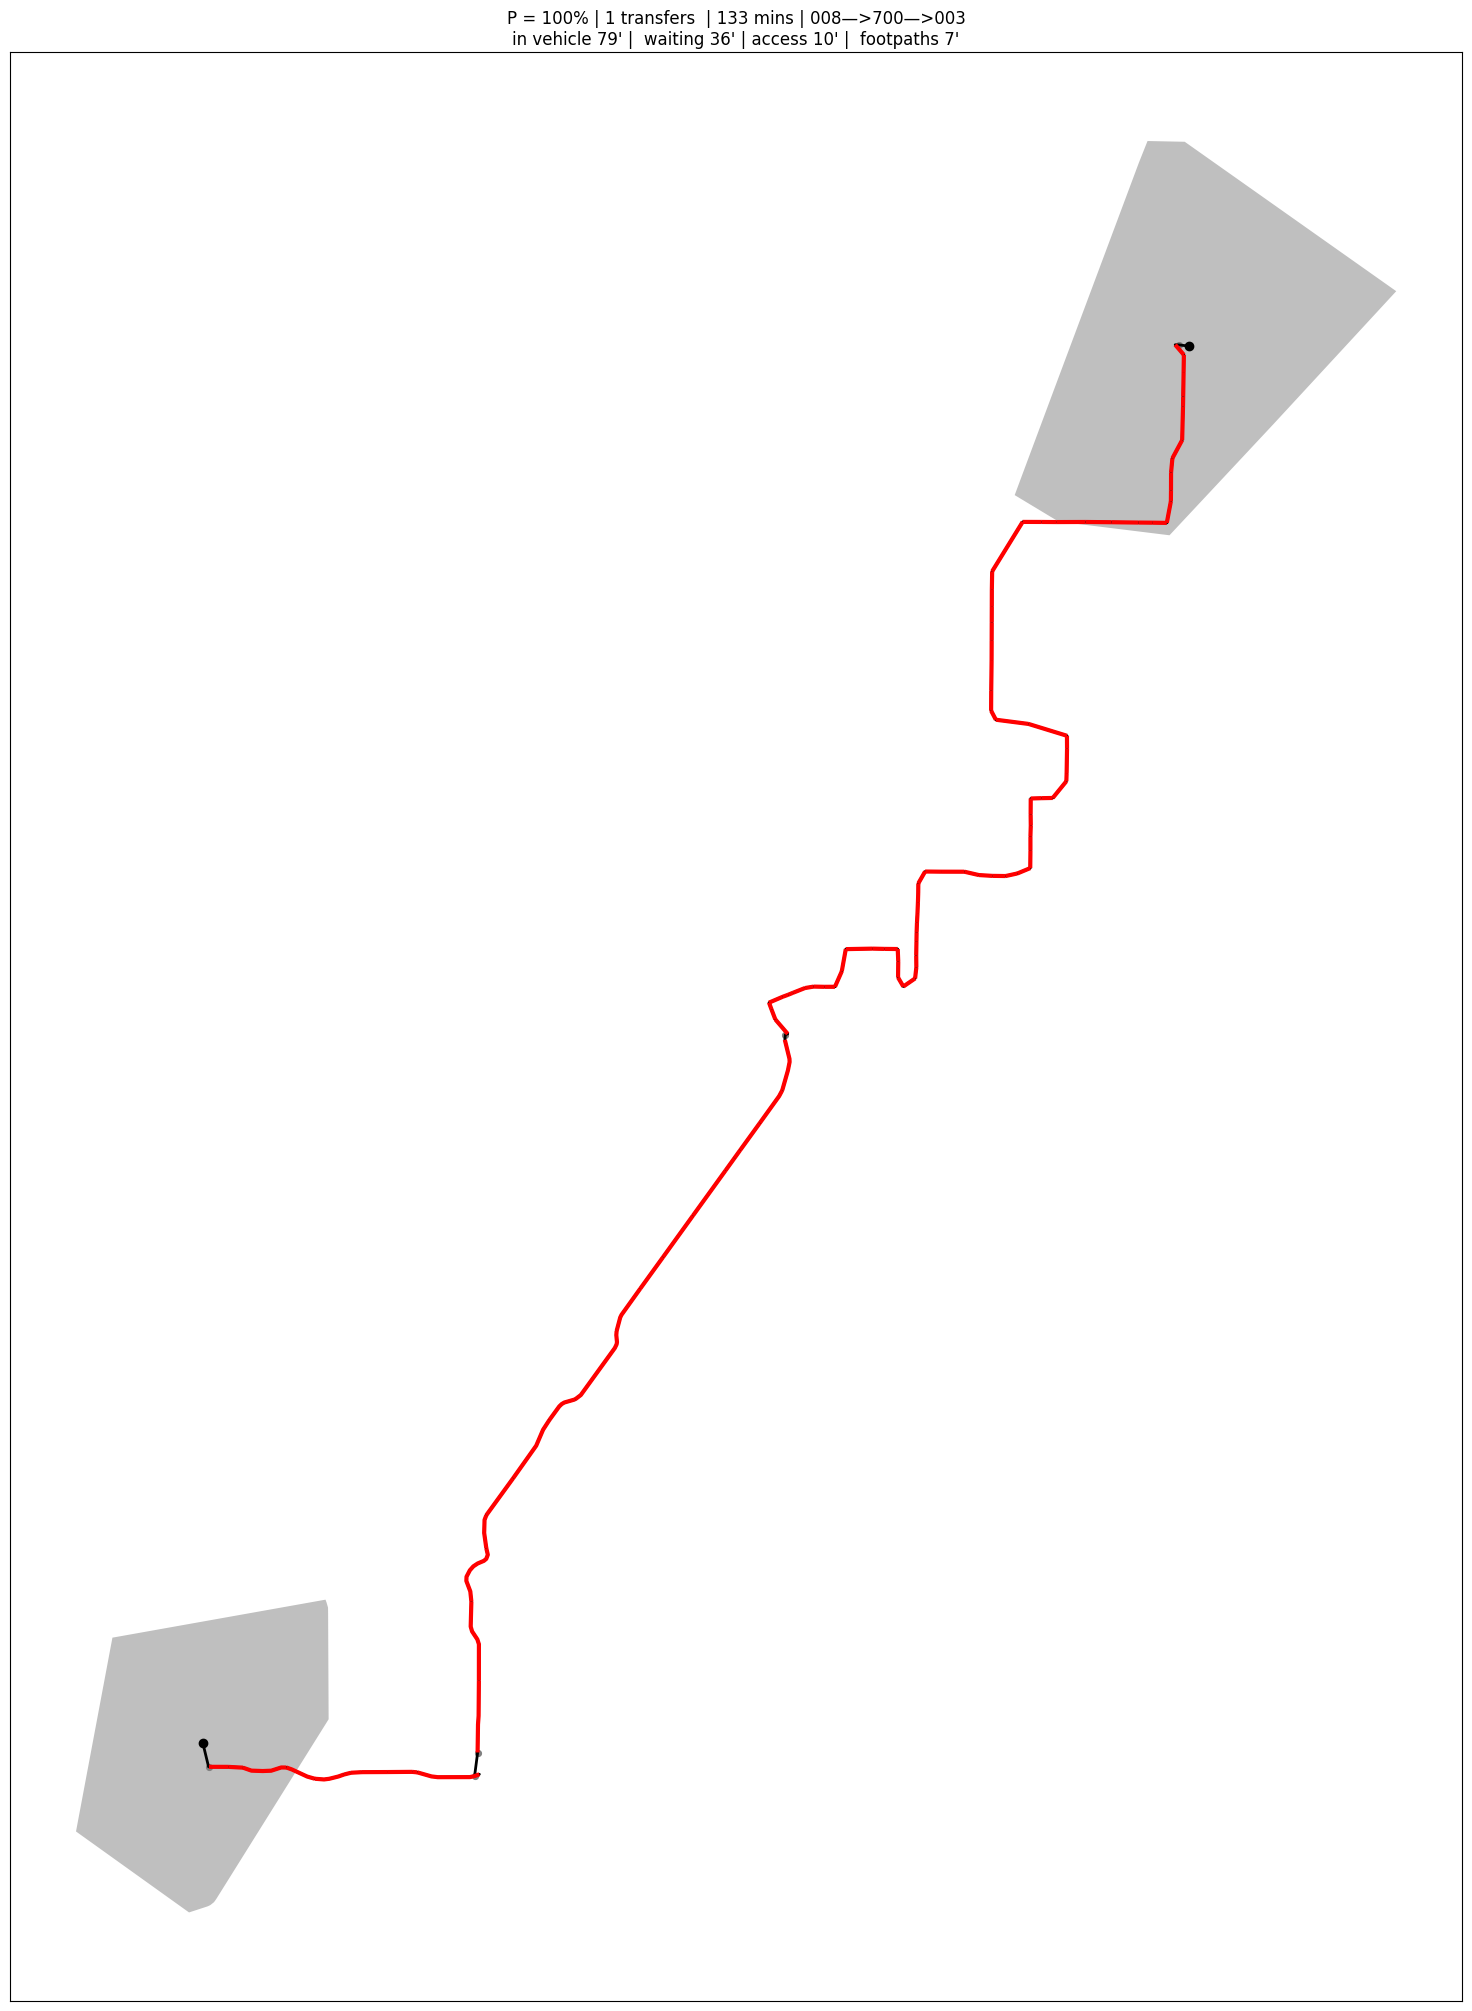

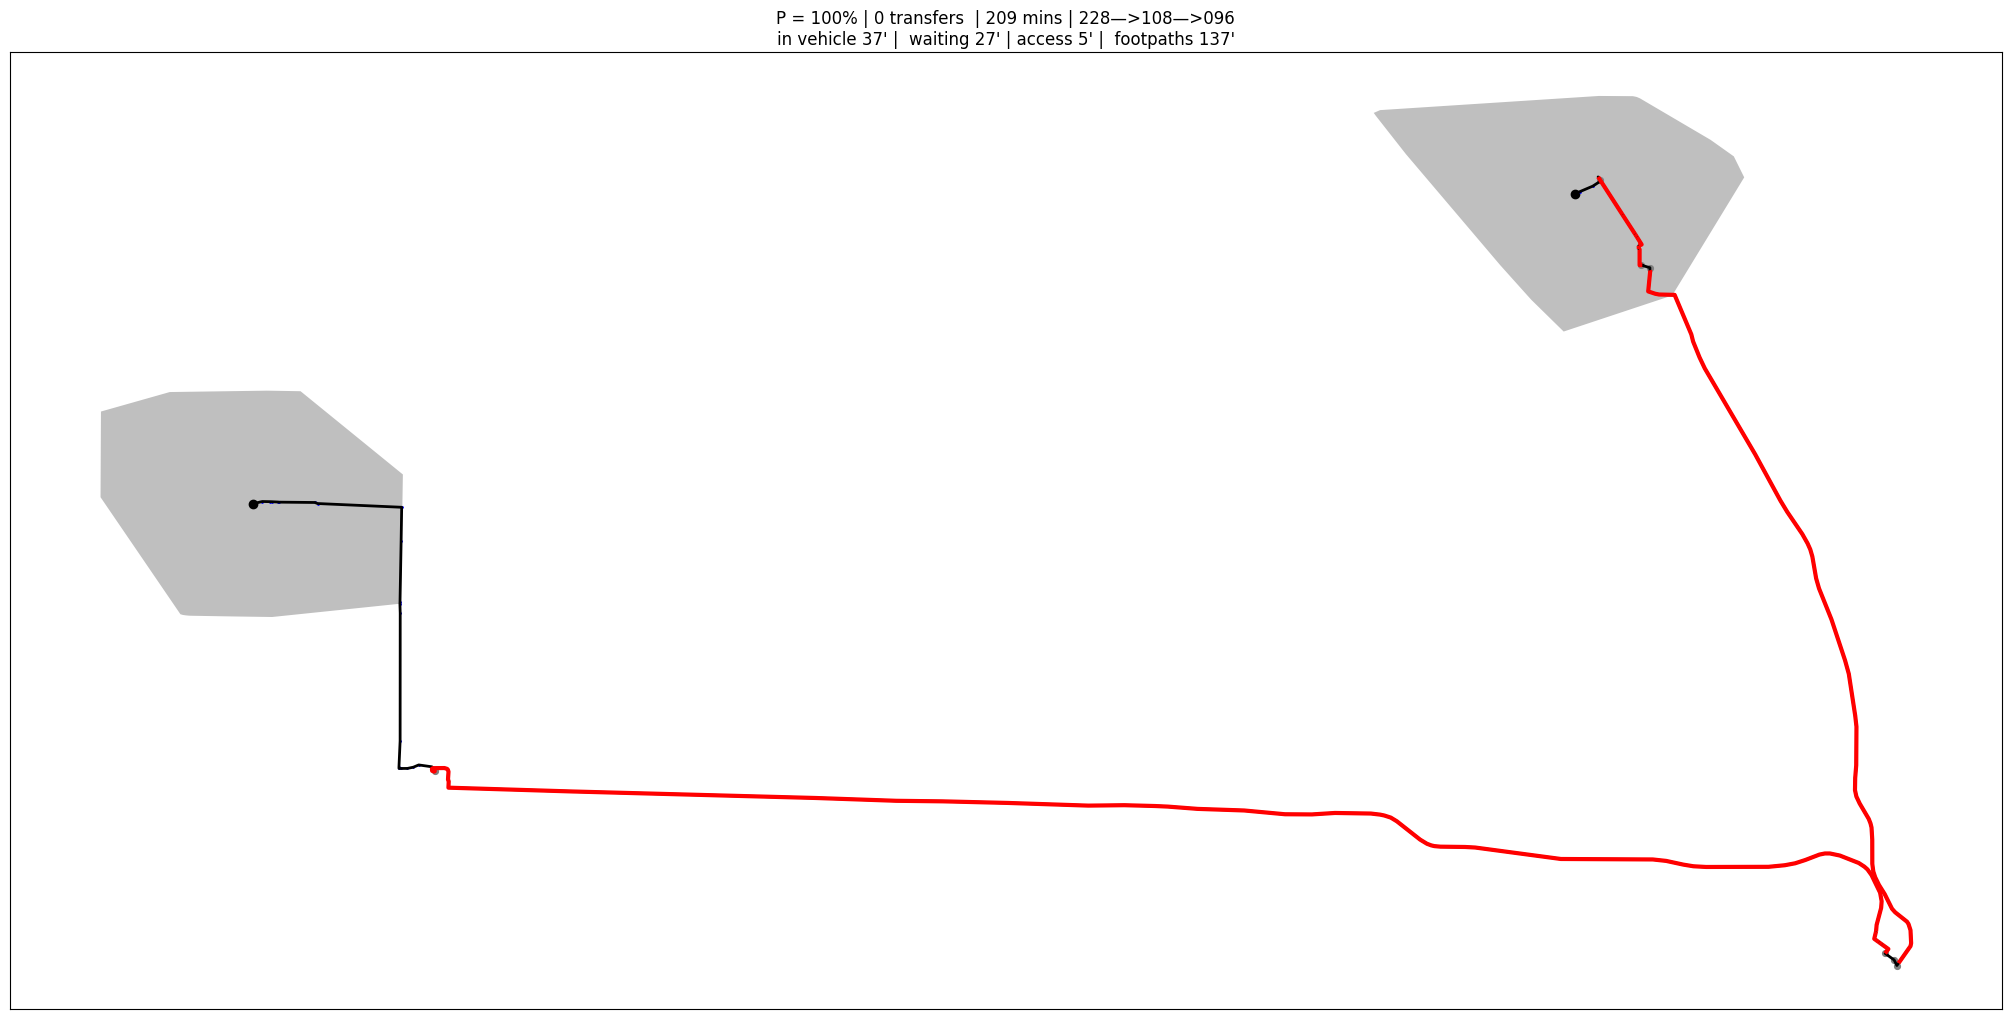

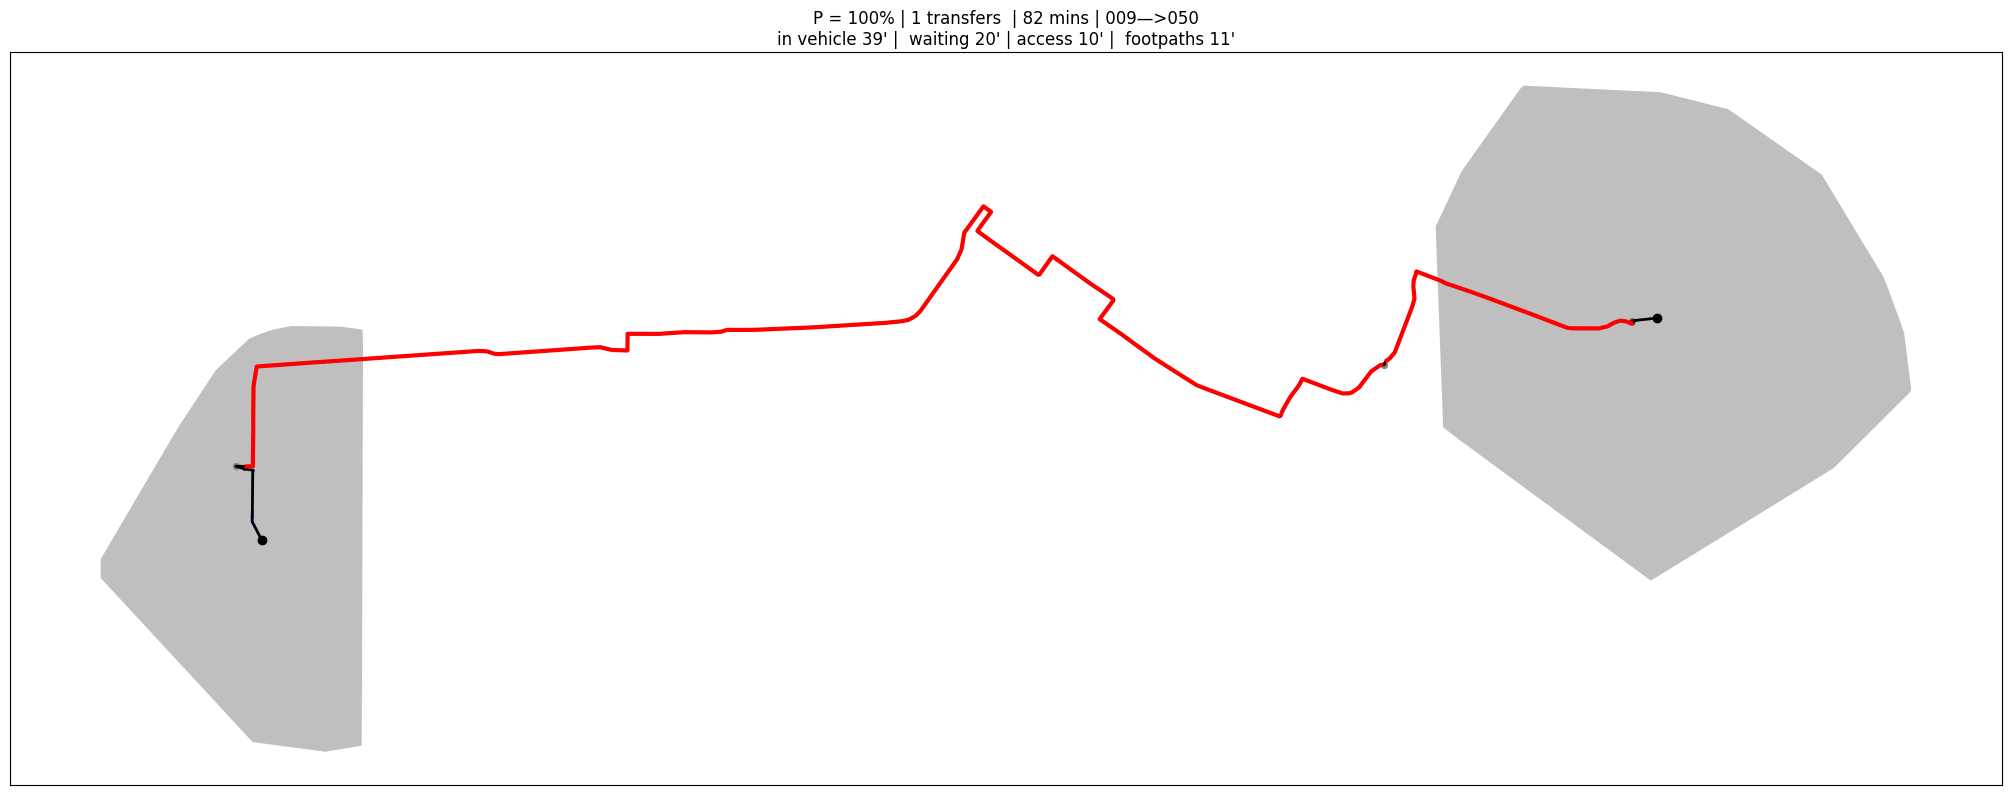

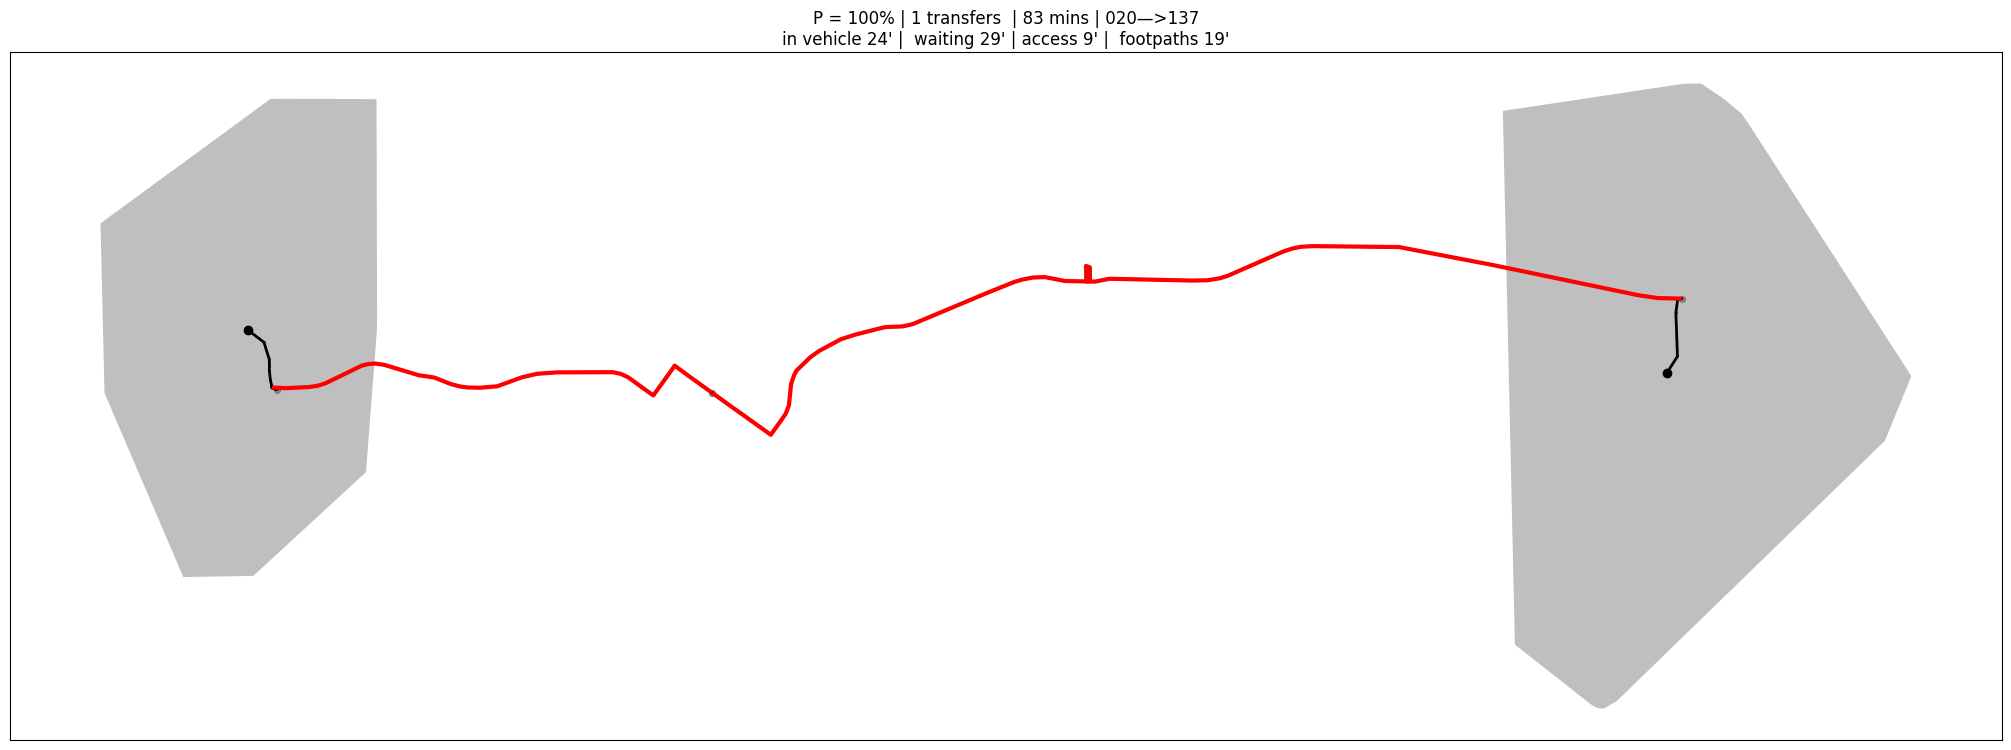

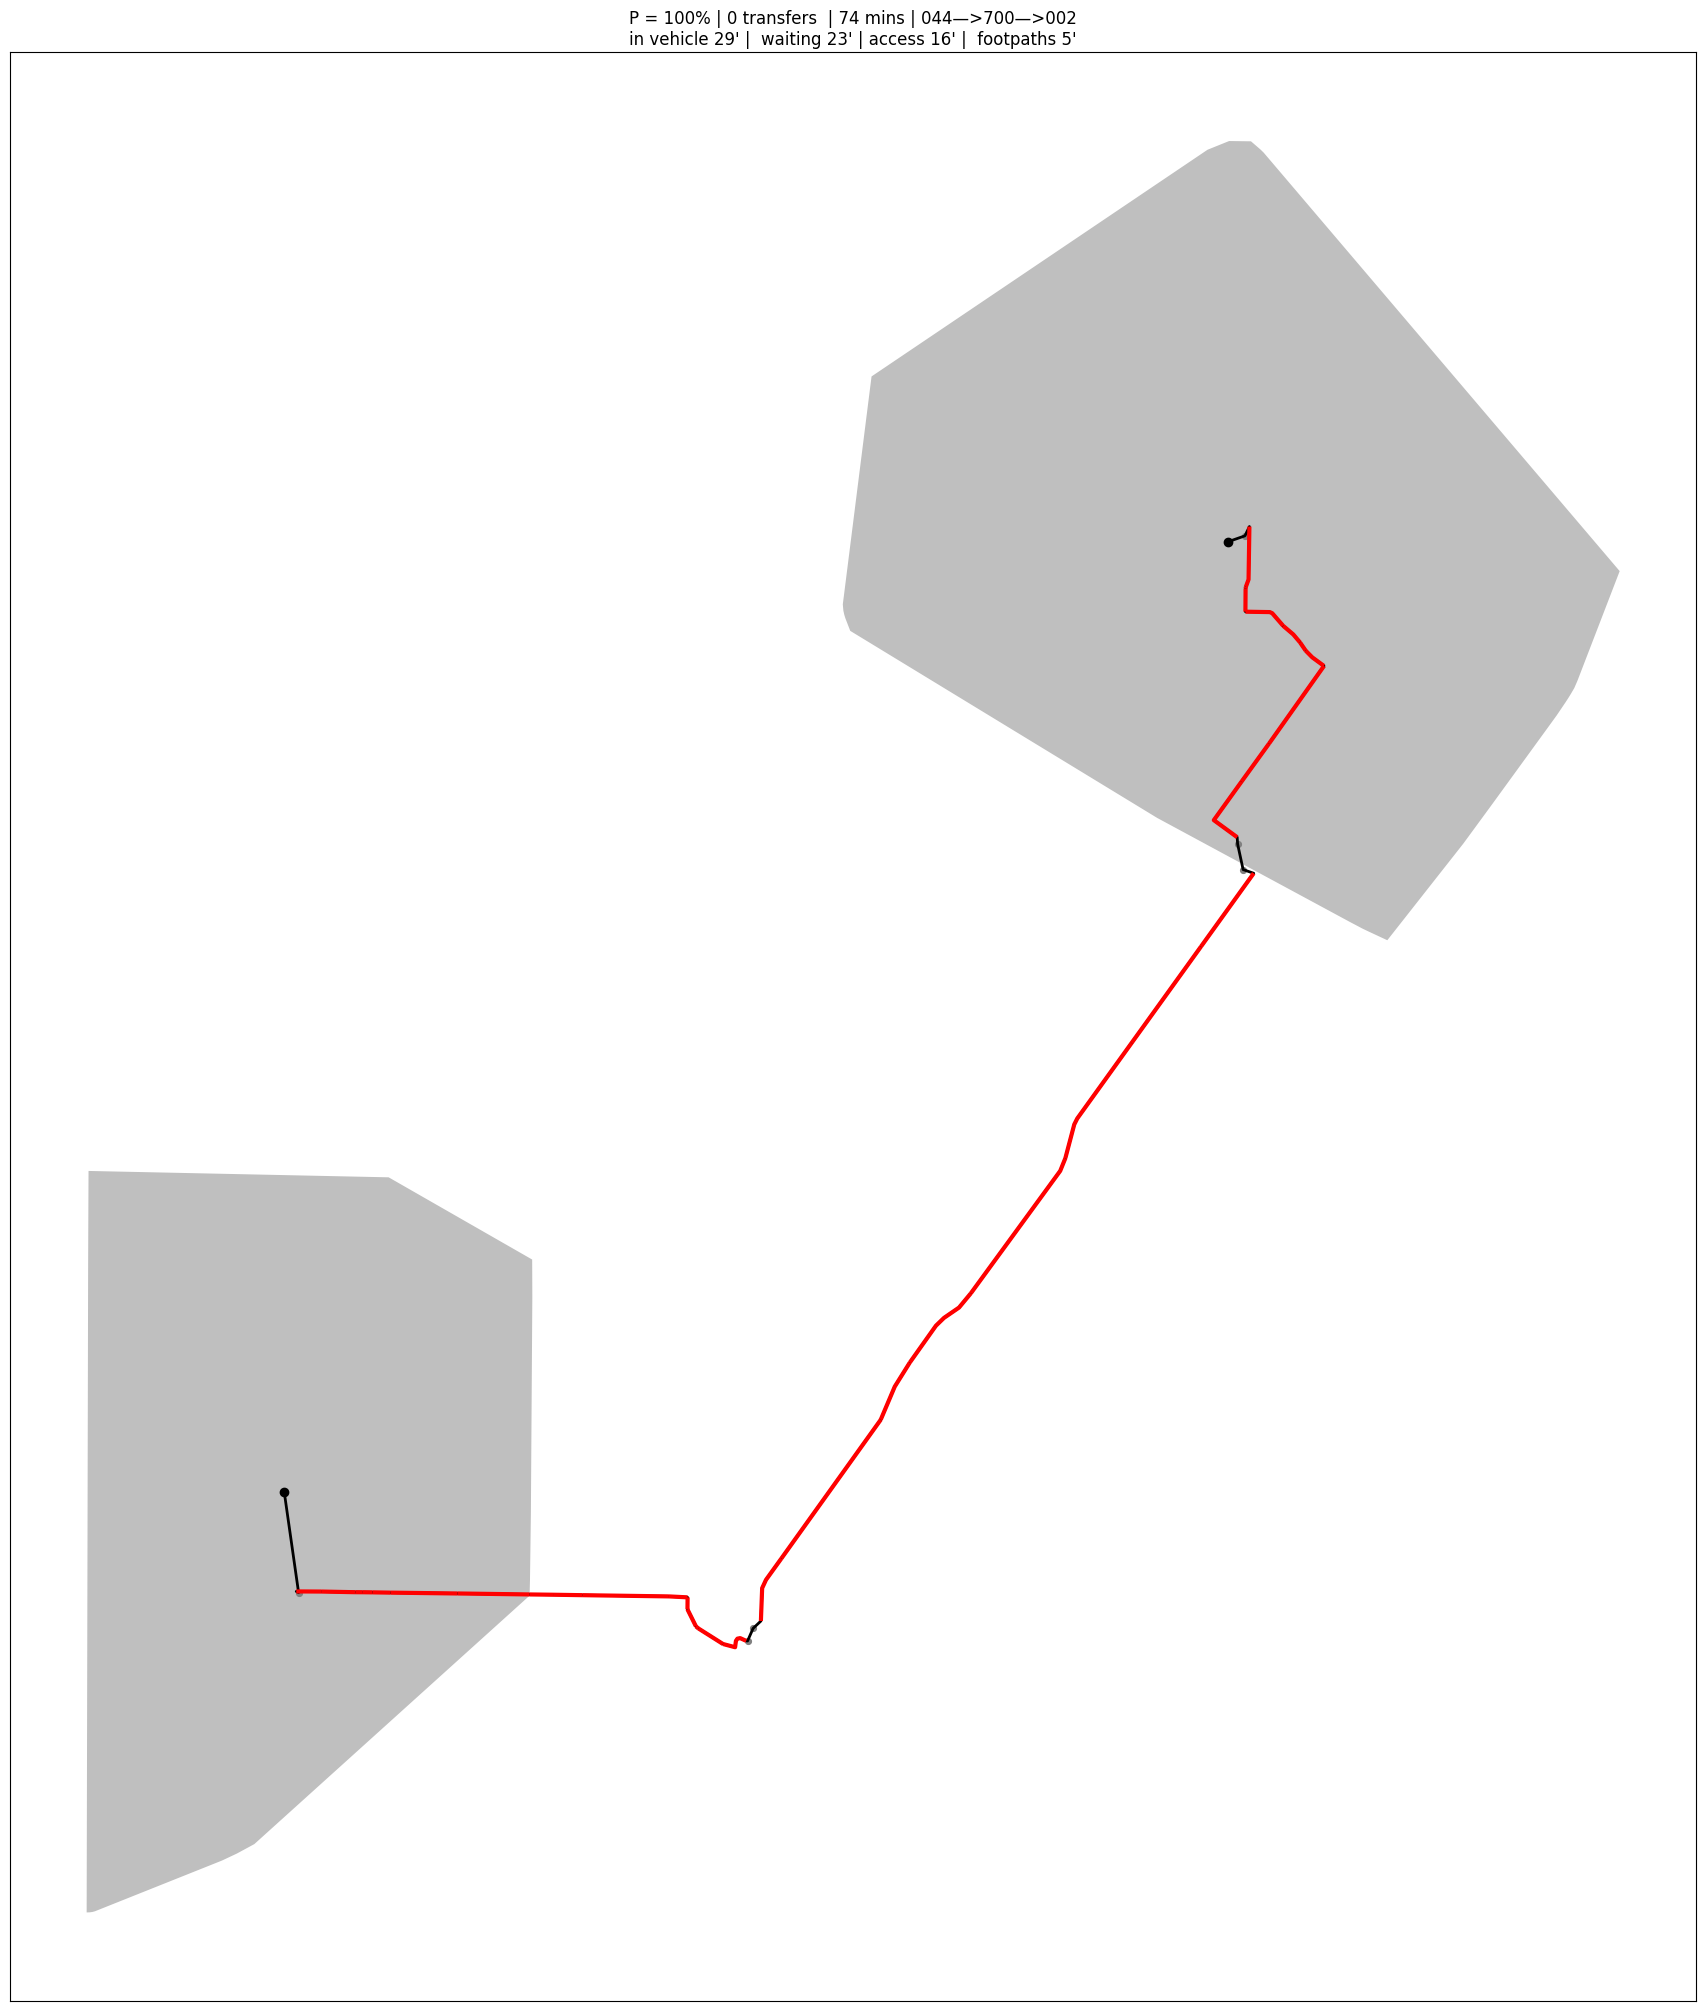

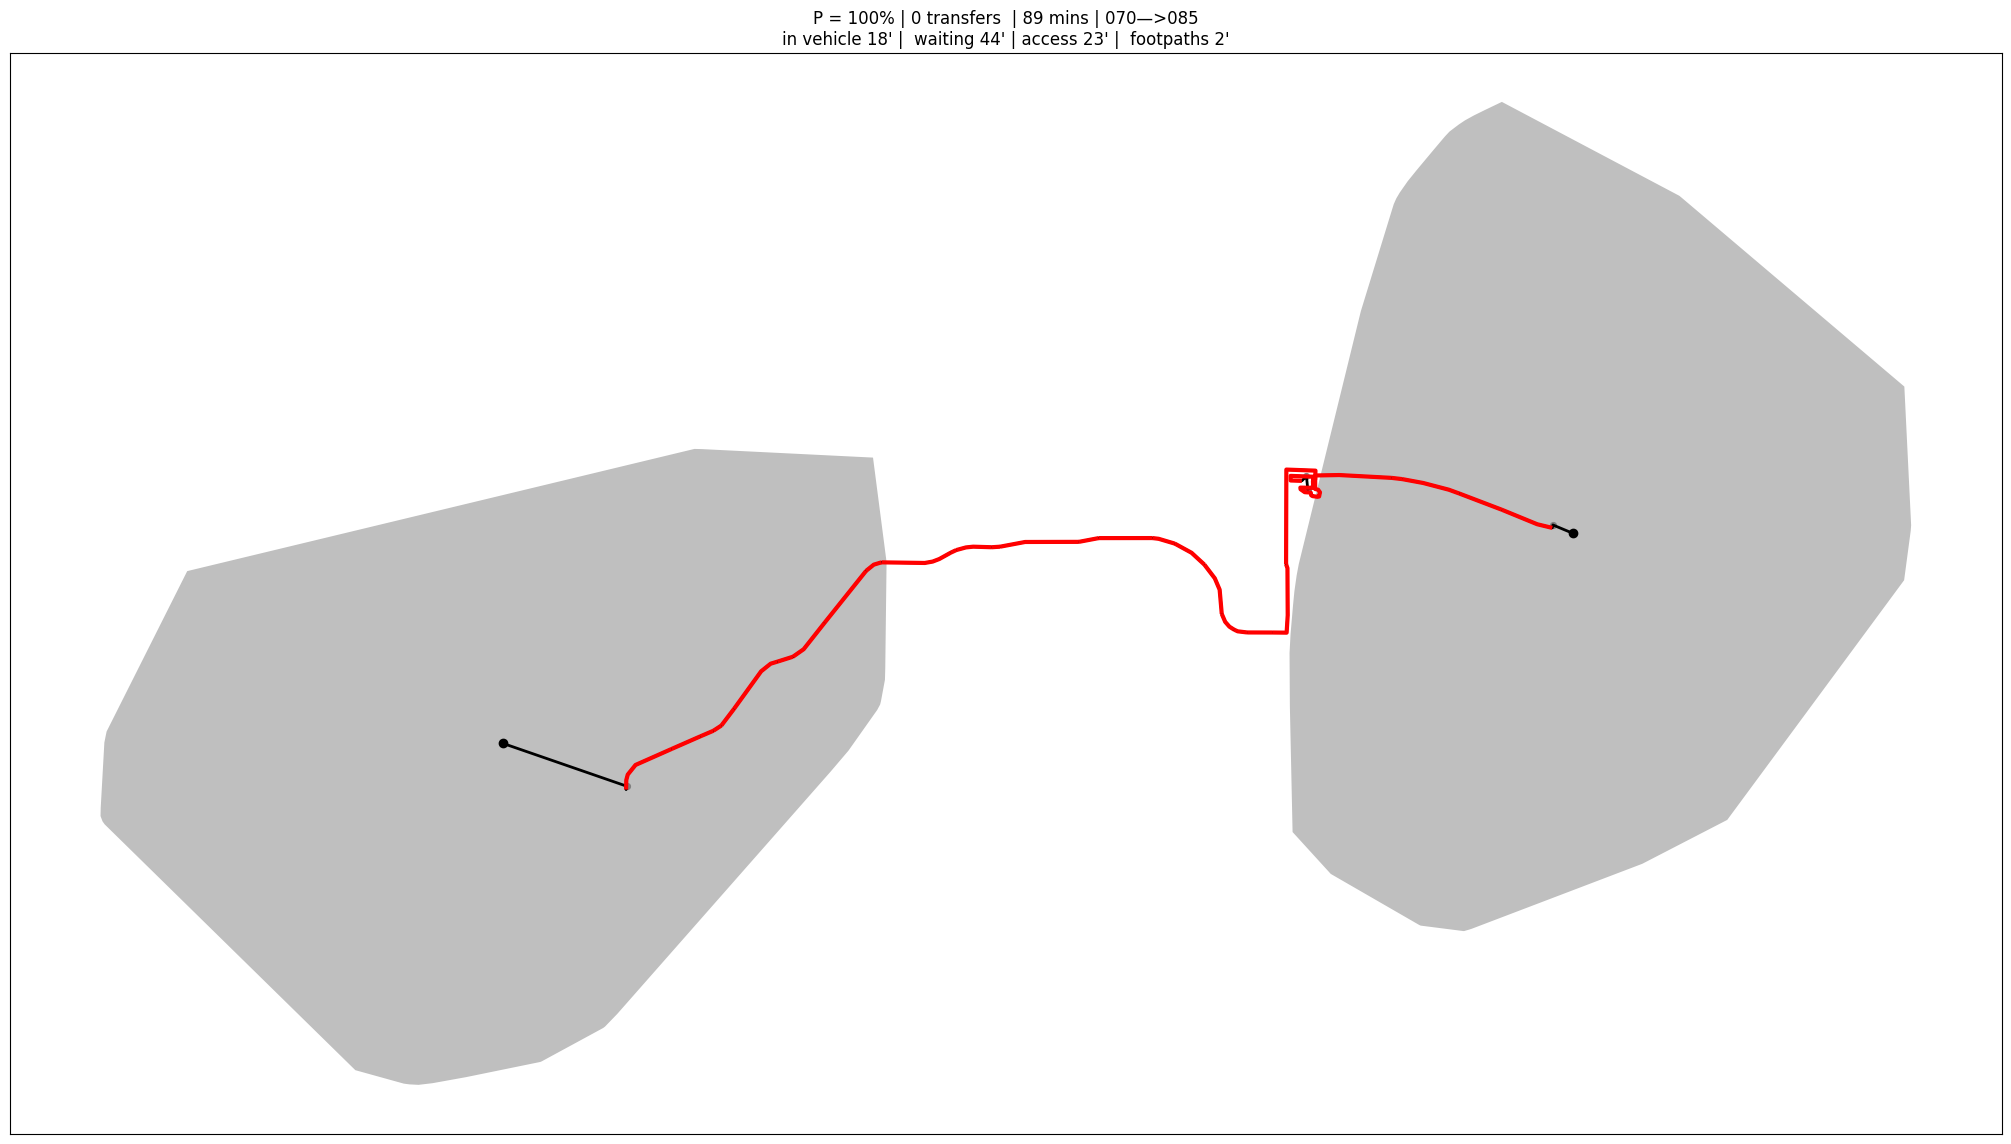

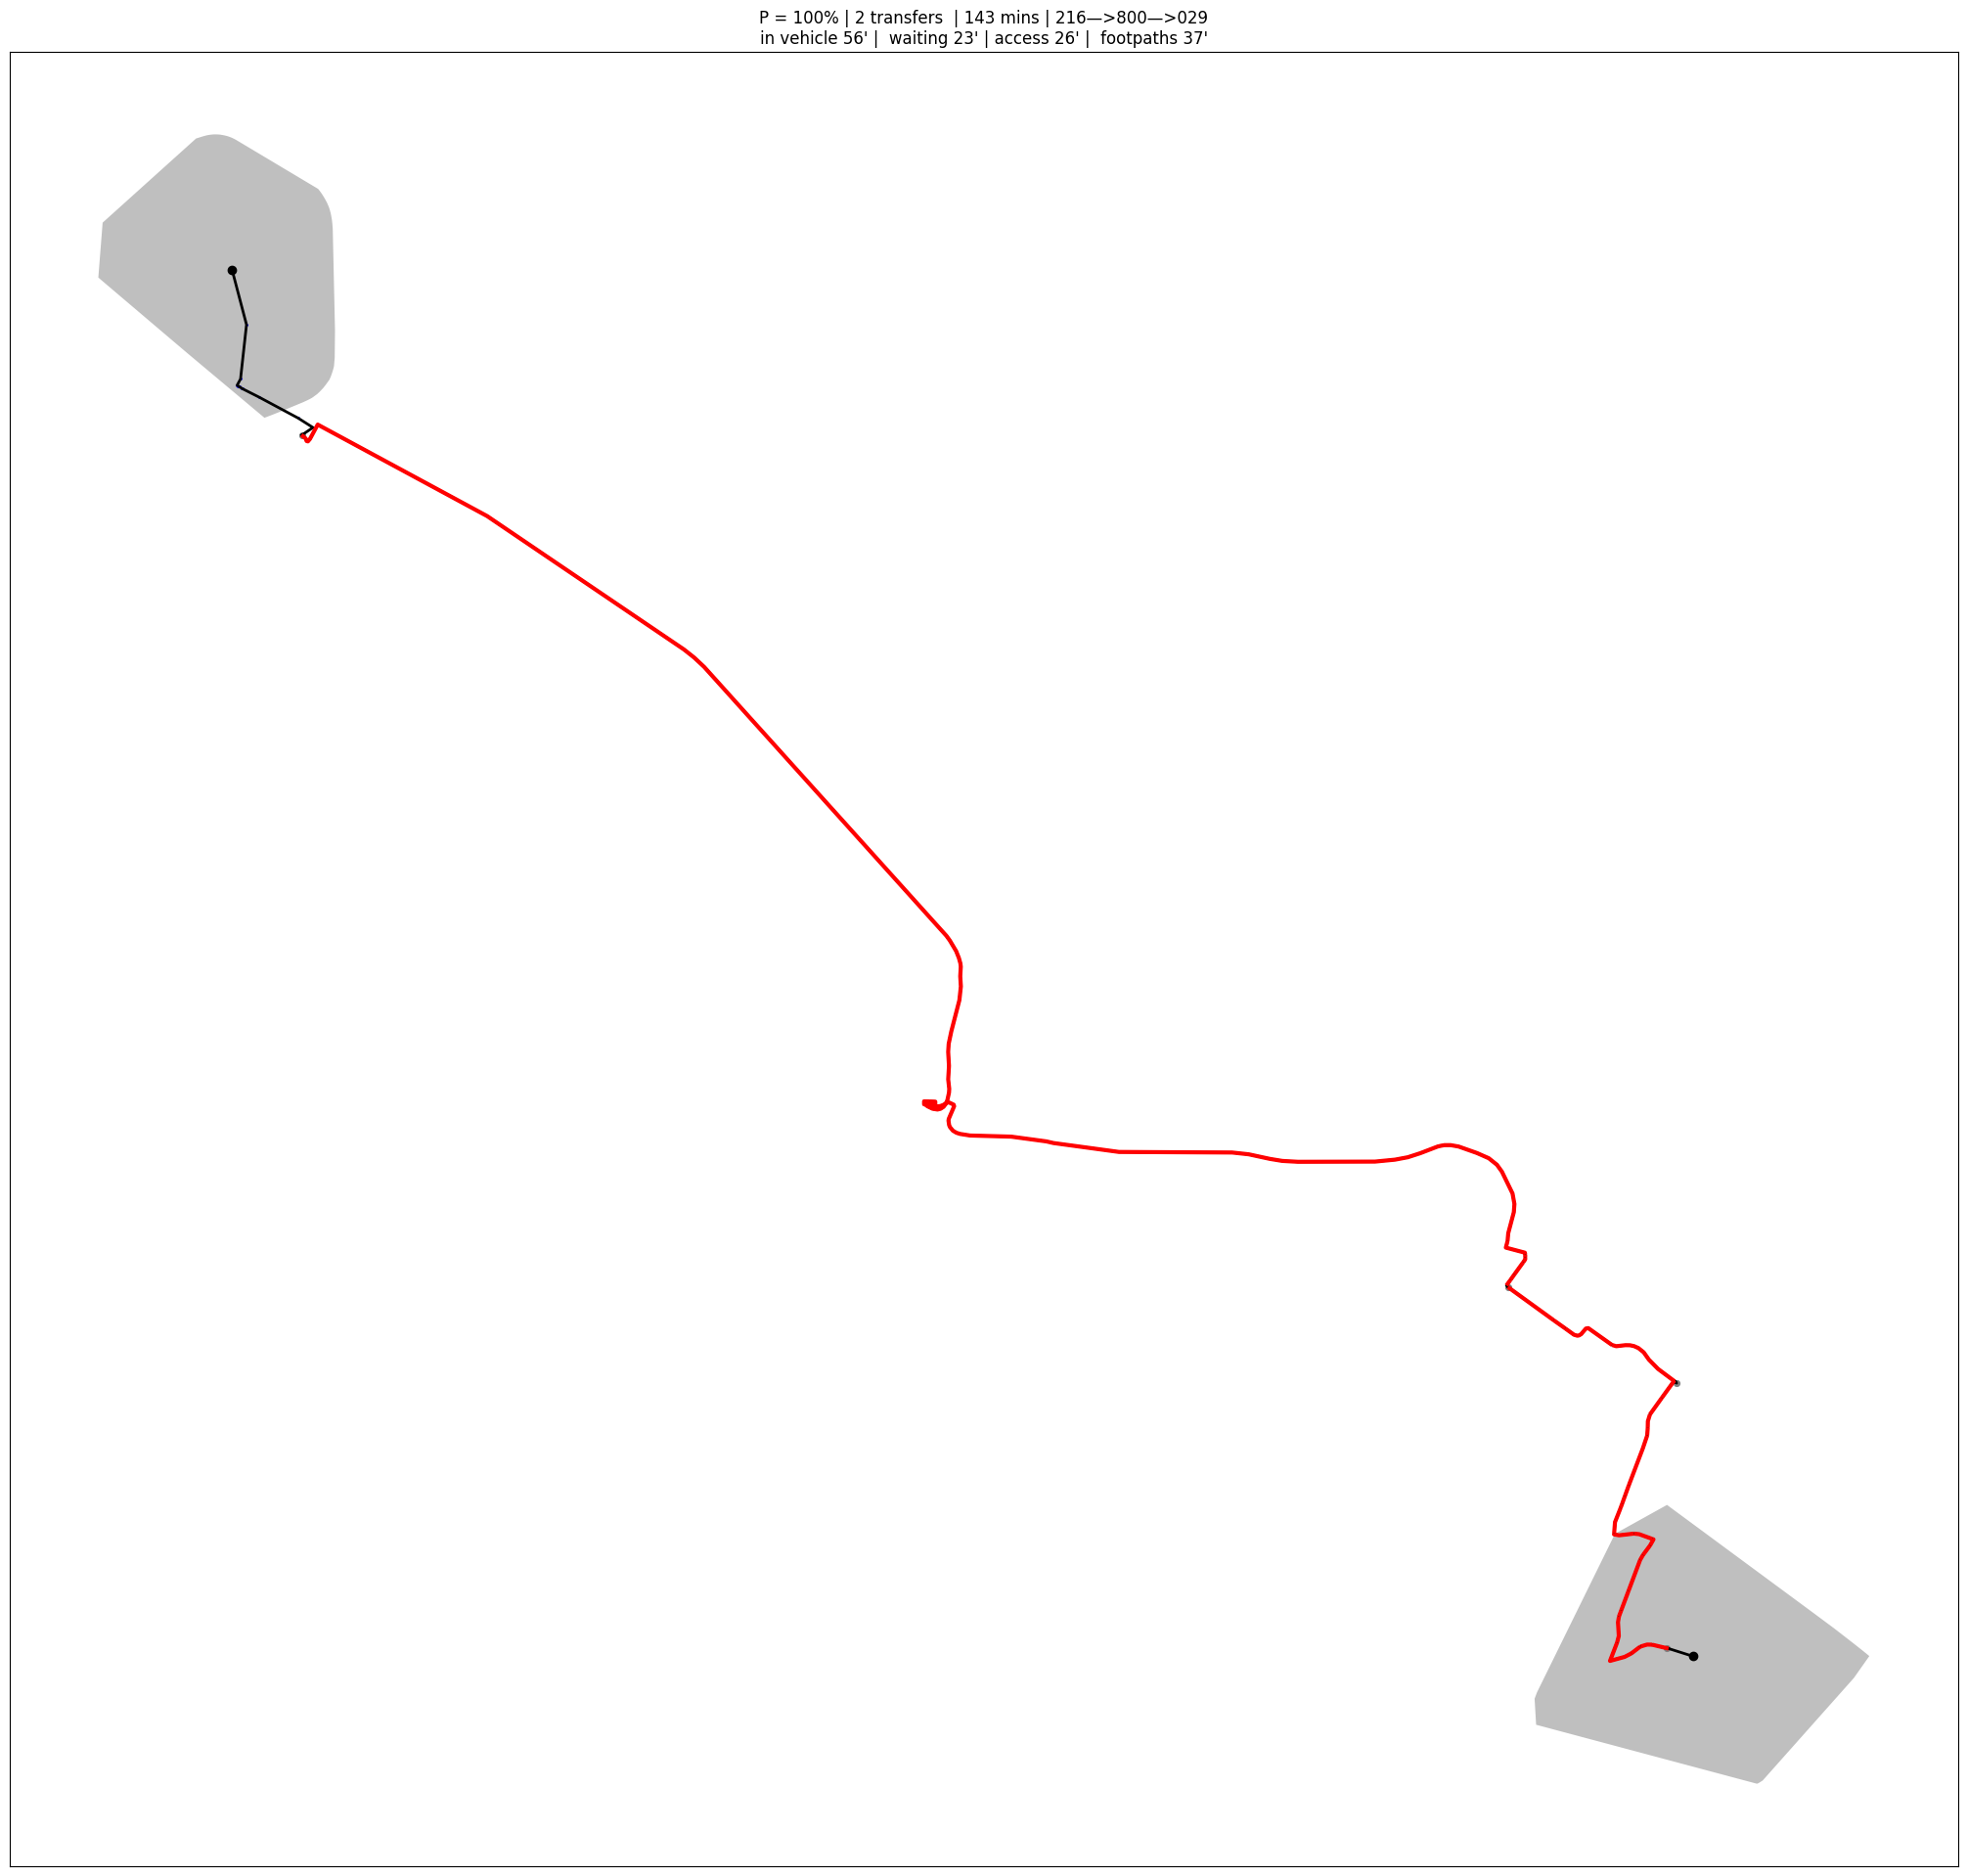

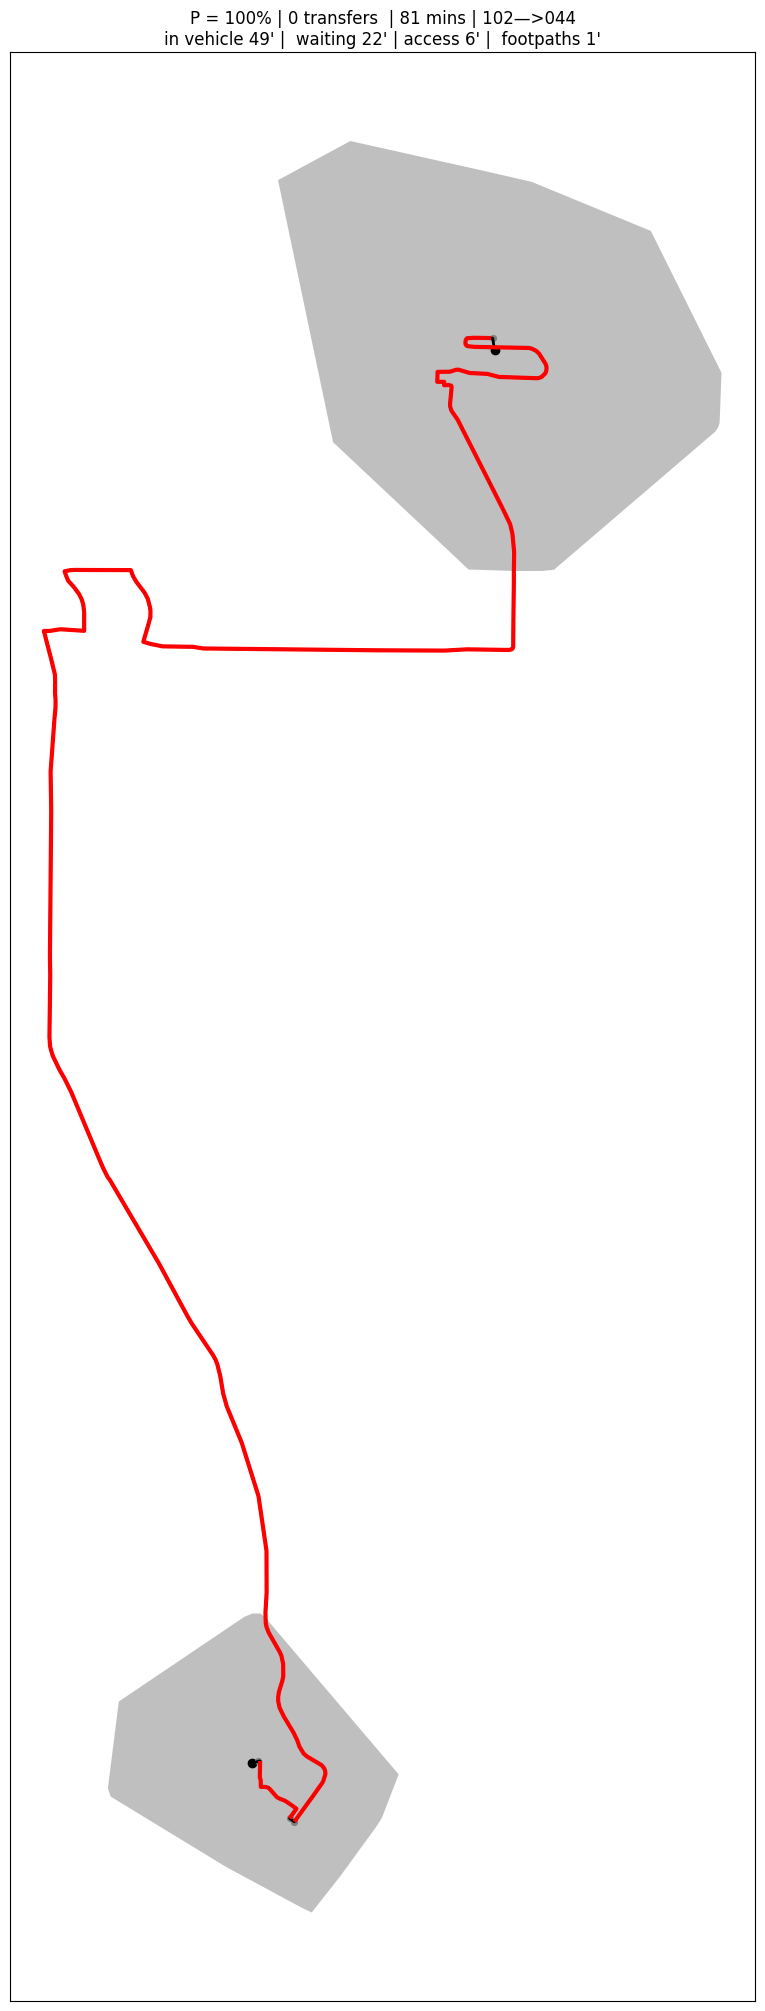

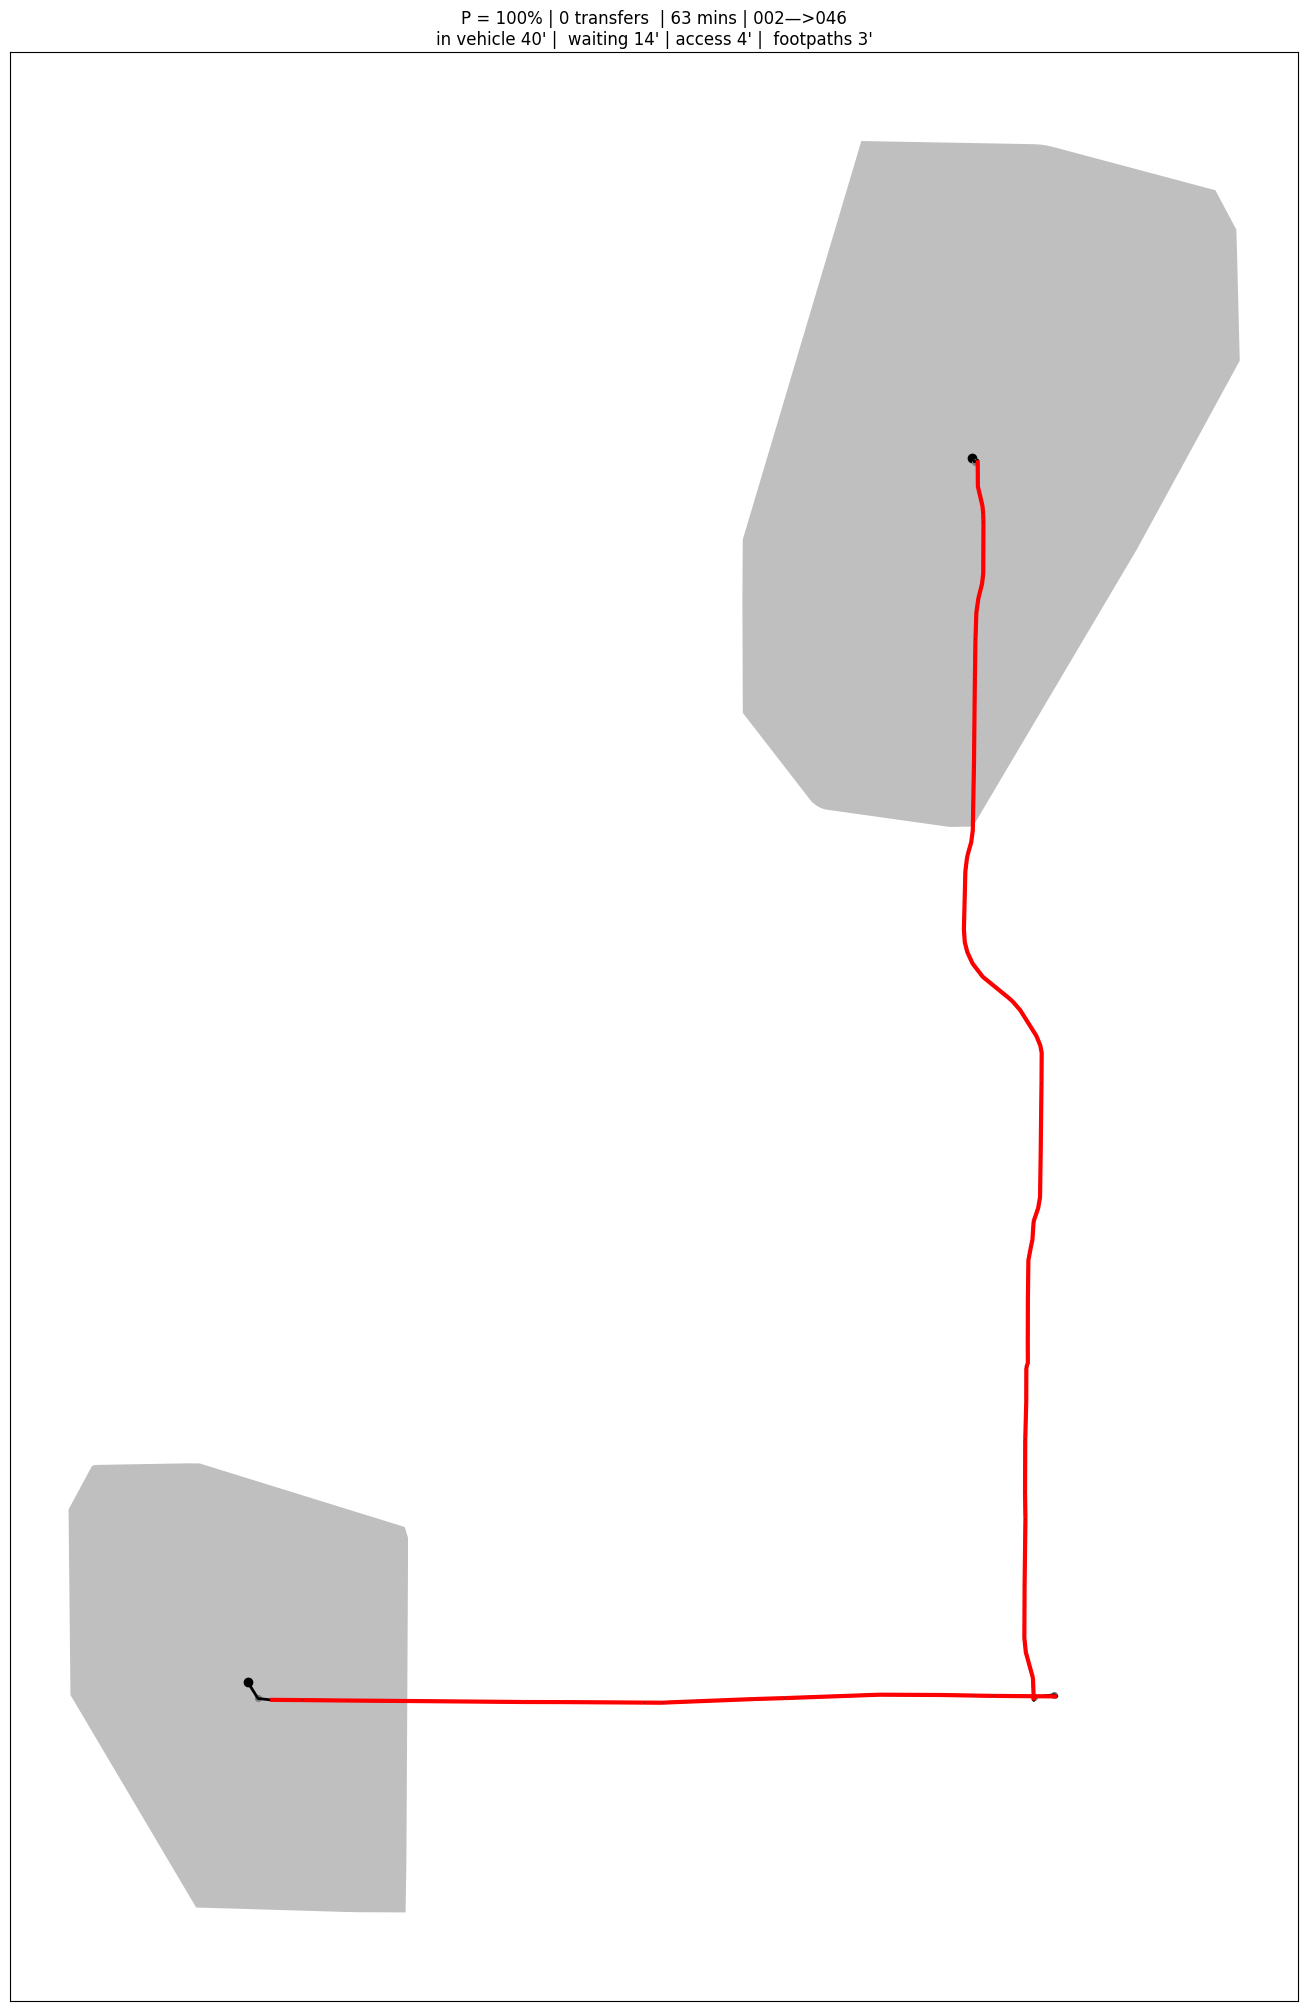

In [44]:

sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)
if manual:

    for o,d in od_list:
        origin, destination= o, d
        n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

        rows = 1

        '''
        if n > 6:
            rows = 3
        if n > 12:
            rows = 4
        '''
        columns = n // rows + bool(n%rows)


        #url = 'http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png'
        fig, axes = sm.plot_separated_paths(
            origin, destination, rows=rows, figsize=[20, 20],
            title='title', constrained_layout=True, zoom=13
        )
        '''
        ax = fig.get_axes()[0]
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
        fig.constrained_layout = True
        '''
#fig.savefig(plot_path + 'logit.png', bbox_inches='tight')